# Multivariate Time Series Forecasting (with Categorical Feature + Classification)

Contributors: michaelmenzel@

In this example, we train a single model from multiple payment events to forecast a next payment event. The data are multiple time series, one per client, with two attributes 'category' and 'value' of a payment in each observation/timestep.

We then train a model which receives the last n observations (parameter LAG) for a client as input, and outputs the expected next observation of a 'category' and mean 'value'.

In [1]:
#@title Imports
import pandas as pd
import numpy as np
import sklearn.preprocessing

import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

print(f"TF version: {tf.__version__}")

TF version: 2.4.1


Let's define the set of clients, the categories in the observations, and the lag used in the input.
We may also define the batch size hyperparameter. 

In [2]:
#Data parameters
CLIENTS = ['A', 'B', 'C'] 
CATEGORIES = ['a', 'b', 'c', 'd']
RANDOM = False
NUM_EXAMPLES_PER_CLIENT = 100000
LAG = 10
BATCH_SIZE = 100

Next, we introduce a range of helper functions to transform our dataset as needed.

In [3]:
#@title Helpers
import collections
import itertools

def gen_categorical(i, categories, isrand=False):
  if isrand:
      return np.random.choice(categories)
  else:
      return categories[int(i % len(categories))]

def gen_numerical(i, buckets, steps, scale, isrand=False):
  if isrand:
      return float(np.random.randint(1, max) / max)
  else: 
      return float((i % buckets - scale / 2) + i / steps)

def index(l, v):
    try:
        return l.index(v)
    except ValueError:
        return None

def stack_list_items(l):
  return [np.hstack(item) for item in l]

def flatten(l):
  return list(itertools.chain(*l))

def encode_categorical(data, columns, encoders):
  encoded = {}
  for c in data.keys():
    idx = index(columns, c)
    encoded[c] = encoders[idx].transform(data[c]) if idx != None else data[c].values
  return encoded

class HistoricEmbedding:
    def __init__(self, lag, default=0):
        self.lag = lag
        self.default = default
        self.buffer = collections.deque(maxlen=self.lag)
        self._init_buffer()
        
    def _init_buffer(self):
        for i in range(self.lag):
            self.buffer.append(self.default)

    def __call__(self, value):
        self.buffer.popleft()
        self.buffer.append(value)
        return list(self.buffer)

def gen_historic_embedding(data, columns, lag, default=0):
    for c in columns:
      encoder = HistoricEmbedding(lag, default)
      data[c] = list(map(encoder, data[c]))
    return data

def pivot_dict(d: dict, with_key: bool = True) -> list:
    pivoted = []
    for i in range(len(list(d.values())[0])):
      if with_key:
         val = {k: d[k][i] for k in d.keys()}
      else:
        val = [d[k][i] for k in d.keys()]
      pivoted.append(val)
    return pivoted

def drop_initial_observations(hist_embed, n):
    for k in hist_embed.keys():
      hist_embed[k] = hist_embed[k][n:]
    return hist_embed

def expand_embed_dims(hist_embed, columns):
    for k in hist_embed.keys():
      if k in columns and len(np.shape(hist_embed[k])) == 2:
        hist_embed[k] = np.expand_dims(hist_embed[k], -1)
    return hist_embed

def merge_observations(obs1, obs2):
    for k in obs1.keys():
      np.append(obs1[k], obs2[k])
    return obs1

def zip_future_timestep(hist_embed, columns):
    inputs = {c: hist_embed[c][:-1] 
               for c in hist_embed.keys()}
    targets = {f'out_{c}': [hist_embed[c][i+1][-1] 
               for i in range(len(hist_embed[c])-1)]
               for c in columns}
    for k in hist_embed.keys() - columns:
        targets[f'out_{k}'] = hist_embed[k][:-1]
    return (inputs, targets)


## Data Preparation

We can now generate data for all clients with randomized observations. The generated data is then transformed to be usable with tf.data.Dataset.

In [4]:
EMBED_COLS = ['category', 'mean_value', 'q10_value', 'q90_value']
#CATEGORY_SCALES = [NUM_EXAMPLES_PER_CLIENT**c for c, _ in enumerate(CATEGORIES)]

raw_df = {}
enc_data = {'client': [], 'category': [], 'mean_value': [], 'q10_value': [], 'q90_value': []}
data = {}

client_binarizer = sklearn.preprocessing.LabelBinarizer().fit(CLIENTS)
category_binarizer = sklearn.preprocessing.LabelBinarizer().fit(CATEGORIES)


for client in CLIENTS:
  
  raw_df[client] = pd.DataFrame([{'ts': i, 
                     'client': client, 
                     'category': gen_categorical(i, CATEGORIES, RANDOM), 
                     'mean_value': gen_numerical(i, len(CATEGORIES), NUM_EXAMPLES_PER_CLIENT, 1, RANDOM),
                     'q10_value': gen_numerical(i, len(CATEGORIES), NUM_EXAMPLES_PER_CLIENT, 1, RANDOM),
                     'q90_value': gen_numerical(i, len(CATEGORIES), NUM_EXAMPLES_PER_CLIENT, 1, RANDOM)}
                     for i in range(NUM_EXAMPLES_PER_CLIENT)])
  
  prep_data = expand_embed_dims(
      drop_initial_observations(
          gen_historic_embedding(
              encode_categorical(
                  raw_df[client].drop(columns=['ts']), 
                  ['client', 'category'], 
                  [client_binarizer, category_binarizer]),
              EMBED_COLS,
              LAG), 
          LAG-1), 
      EMBED_COLS)
  enc_data = merge_observations(prep_data, enc_data)
      

data = zip_future_timestep(enc_data, EMBED_COLS)

raw_df['A']

,ts,client,category,mean_value,q10_value,q90_value
0,0,A,a,-0.50000,-0.50000,-0.50000
1,1,A,b,0.50001,0.50001,0.50001
2,2,A,c,1.50002,1.50002,1.50002
3,3,A,d,2.50003,2.50003,2.50003
4,4,A,a,-0.49996,-0.49996,-0.49996
...,...,...,...,...,...,...
99995,99995,A,d,3.49995,3.49995,3.49995
99996,99996,A,a,0.49996,0.49996,0.49996
99997,99997,A,b,1.49997,1.49997,1.49997
99998,99998,A,c,2.49998,2.49998,2.49998


In [5]:
dataset = (tf.data.Dataset.from_tensor_slices(data)
    .batch(BATCH_SIZE, drop_remainder=True)
    .cache()
    .prefetch(tf.data.AUTOTUNE))

DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE*.8)
VAL_SIZE = int(DATASET_SIZE*.1)
TEST_SIZE = int(DATASET_SIZE*.1)

ds_train = dataset.take(TRAIN_SIZE)
ds_val = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
ds_test = dataset.skip(TRAIN_SIZE+VAL_SIZE).take(TEST_SIZE)

input_sample, target_sample = next(iter(ds_test))

## Model Definition

In [6]:
inputs = {k: tf.keras.Input(name=k, shape=tf.shape(input_sample[k])[1:]) for k in input_sample.keys()}
lstm_inputs = tf.keras.layers.concatenate([inputs[k] for k in EMBED_COLS])
lstm_val = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=LAG, return_sequences=True))(lstm_inputs)
lstm_cat = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=LAG, return_sequences=True))(lstm_inputs)

flat_val = tf.keras.layers.Flatten()(lstm_val)
flat_cat = tf.keras.layers.Flatten()(lstm_cat)

out_client = tf.keras.layers.Activation('linear', name='out_client')(inputs['client'])
out_category = tf.keras.layers.Dense(units=len(CATEGORIES), name='out_category', activation='softmax')(flat_cat)
mlp_val = tf.keras.layers.Dense(units=10, activation='sigmoid')(flat_val)
out_mean_value = tf.keras.layers.Dense(units=1, name='out_mean_value', activation='relu')(mlp_val)
out_q10_value = tf.keras.layers.Dense(units=1, name='out_q10_value', activation='relu')(mlp_val)
out_q90_value = tf.keras.layers.Dense(units=1, name='out_q90_value', activation='relu')(mlp_val)

model = tf.keras.Model(name='payment_forecast_model', inputs=inputs, outputs=[out_client, out_category, out_mean_value, out_q10_value, out_q90_value])
model.summary()

Model: "payment_forecast_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category (InputLayer)           [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
mean_value (InputLayer)         [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
q10_value (InputLayer)          [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
q90_value (InputLayer)          [(None, 10, 1)]      0                                            
_____________________________________________________________________________

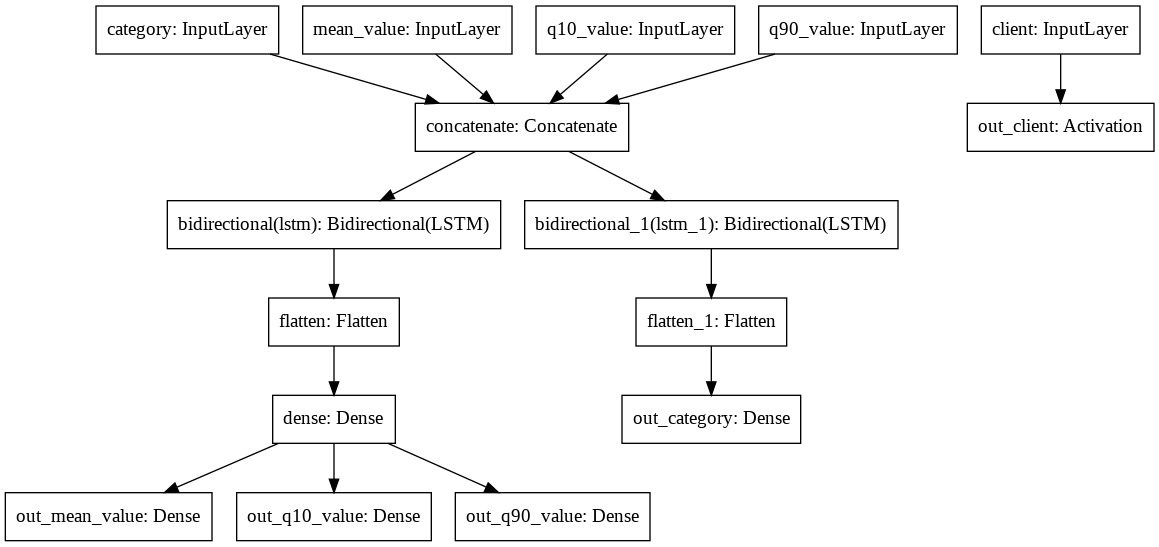

In [7]:
tf.keras.utils.plot_model(model)

In [8]:
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, quantile, **kwargs):
        self.quantile = quantile
        super(QuantileLoss, self).__init__(**kwargs)

    def call(self, y_true, y_pred):
      prediction_underflow = y_true - y_pred
      return self.quantile * tf.maximum(prediction_underflow, 0.) + (
          1. - self.quantile) * tf.maximum(-prediction_underflow, 0.)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0003), 
    loss={'out_client': 'categorical_crossentropy', 'out_category': 'categorical_crossentropy', 'out_mean_value': 'huber', 'out_q10_value': QuantileLoss(.1), 'out_q90_value': QuantileLoss(.9)},
    metrics={'out_client': 'categorical_accuracy', 'out_category': 'categorical_accuracy', 'out_mean_value': 'mape'})

## Model Training & Test

In [9]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=2, restore_best_weights=True
)
history = model.fit(ds_train, 
                    validation_data=ds_val,
                    epochs=100, 
                    steps_per_epoch=TRAIN_SIZE,
                    validation_steps=VAL_SIZE,
                    callbacks=[earlystop_cb])

Epoch 1/100
799/799 [==============================] - 17s 14ms/step - loss: 2.1450 - out_client_loss: 1.1921e-07 - out_category_loss: 0.6749 - out_mean_value_loss: 0.9303 - out_q10_value_loss: 0.1969 - out_q90_value_loss: 0.3429 - out_client_categorical_accuracy: 1.0000 - out_category_categorical_accuracy: 0.8322 - out_mean_value_mape: 99.9994 - val_loss: 1.7501 - val_out_client_loss: 1.1921e-07 - val_out_category_loss: 0.0079 - val_out_mean_value_loss: 1.4017 - val_out_q10_value_loss: 0.1849 - val_out_q90_value_loss: 0.1557 - val_out_client_categorical_accuracy: 1.0000 - val_out_category_categorical_accuracy: 1.0000 - val_out_mean_value_mape: 100.0000
Epoch 2/100
799/799 [==============================] - 9s 11ms/step - loss: 1.2469 - out_client_loss: 1.1921e-07 - out_category_loss: 0.0061 - out_mean_value_loss: 0.9275 - out_q10_value_loss: 0.1969 - out_q90_value_loss: 0.1164 - out_client_categorical_accuracy: 1.0000 - out_category_categorical_accuracy: 1.0000 - out_mean_value_mape: 

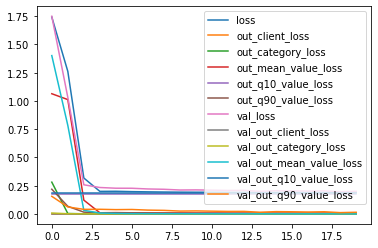

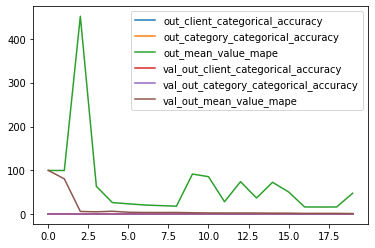

In [10]:
losses = list(filter(lambda x: 'loss' in x, history.history.keys()))
for metric in losses:
    plt.plot(history.history[metric])
plt.legend(losses)
plt.show()

accs = list(filter(lambda x: any(y in x for y in ['mape', 'accuracy']), history.history.keys()))
for metric in accs:
    plt.plot(history.history[metric])
plt.legend(accs)
plt.show()

In [11]:
#print('input:', input_sample)
pred_clients, pred_categories, pred_mean_values, pred_q10_values, pred_q90_values = model(input_sample)
act_categories, act_mean_values, act_q10_values, act_q90_values, act_clients = target_sample.values()
for pred_client, act_client, pred_cat, act_cat, pred_val, act_val, pred_q10_val, act_q10_val, pred_q90_val, act_q90_val in zip(pred_clients, act_clients, pred_categories, act_categories, pred_mean_values, act_mean_values, pred_q10_values, act_q10_values, pred_q90_values, act_q90_values):
    print('client:', CLIENTS[tf.argmax(pred_client)], 'vs.', CLIENTS[tf.argmax(act_client)])
    print('category:', CATEGORIES[tf.argmax(pred_cat)], 'vs.', CATEGORIES[tf.argmax(act_cat)])
    print('mean:', pred_val.numpy(), 'vs.', act_val.numpy())
    print('q10:', pred_q10_val.numpy(), 'vs.', act_q10_val.numpy())
    print('q90:', pred_q90_val.numpy(), 'vs.', act_q90_val.numpy())


client: C vs. C
category: c vs. c
mean: [2.346929] vs. [2.3981]
q10: [0.] vs. [2.3981]
q90: [2.3534505] vs. [2.3981]
client: C vs. C
category: d vs. d
mean: [3.3271592] vs. [3.39811]
q10: [0.] vs. [3.39811]
q90: [3.3413255] vs. [3.39811]
client: C vs. C
category: a vs. a
mean: [0.35387084] vs. [0.39812]
q10: [0.] vs. [0.39812]
q90: [0.3512569] vs. [0.39812]
client: C vs. C
category: b vs. b
mean: [1.3787972] vs. [1.39813]
q10: [0.] vs. [1.39813]
q90: [1.3603797] vs. [1.39813]
client: C vs. C
category: c vs. c
mean: [2.3469474] vs. [2.39814]
q10: [0.] vs. [2.39814]
q90: [2.3534684] vs. [2.39814]
client: C vs. C
category: d vs. d
mean: [3.3271697] vs. [3.39815]
q10: [0.] vs. [3.39815]
q90: [3.3413377] vs. [3.39815]
client: C vs. C
category: a vs. a
mean: [0.3538934] vs. [0.39816]
q10: [0.] vs. [0.39816]
q90: [0.35127681] vs. [0.39816]
client: C vs. C
category: b vs. b
mean: [1.3788278] vs. [1.39817]
q10: [0.] vs. [1.39817]
q90: [1.3604026] vs. [1.39817]
client: C vs. C
category: c vs. c
